In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

In [2]:
def plot_basemap(region, feature=True):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
    ax.set_extent(region, crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=['left', 'bottom'],
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    if feature:
        ax.coastlines()
        # plot land
        ax.add_feature(cfeature.LAND)
    return ax

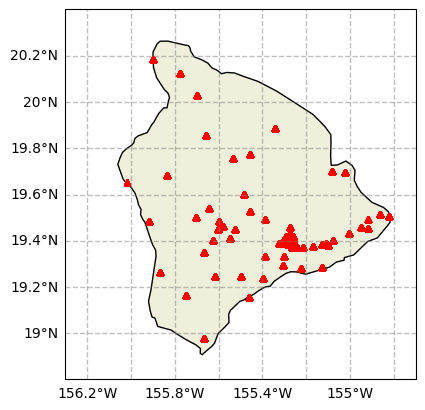

In [3]:
region = [-156.3, -154.7, 18.8, 20.4]
sr = pd.read_csv('src_rec_file_raw.csv')
ax = plot_basemap(region)
ax.plot(sr['stlo'], sr['stla'], 'r^', markersize=5, transform=ccrs.PlateCarree())
ax.plot(sr['evlo'], sr['evla'], 'r^', markersize=5, transform=ccrs.PlateCarree())

In [4]:
! gmt grdcut @earth_relief_01m -R-157/-152/18/21 -Ghawaii.nc

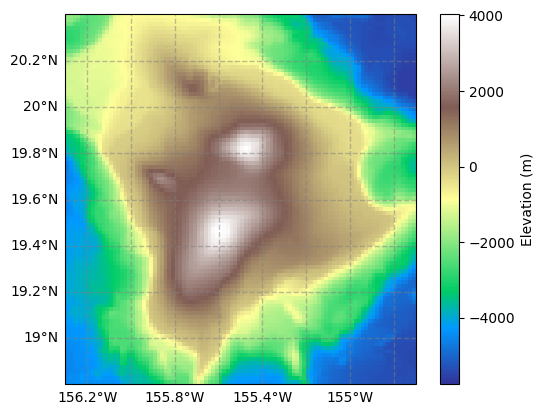

In [5]:
topo = xr.open_dataset('hawaii.nc')
# plot topography
ax = plot_basemap(region, feature=False)
h = ax.pcolormesh(topo.lon, topo.lat, topo.z, transform=ccrs.PlateCarree(), cmap='terrain')
plt.colorbar(h, ax=ax, label='Elevation (m)')

## Rotate stations

In [6]:
pos = [19.5, -155.5]
angle = -30

pos_str = f"{pos[0]}/{pos[1]}"
! ../../bin/surfatt_rotate_src_rec -i src_rec_file_raw.csv -a "$angle" -c "$pos_str" -o src_rec_file_rotated.csv

-0.4198 0.5586 -0.3714 0.6717


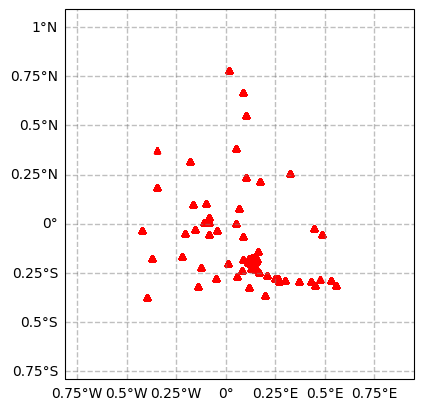

In [7]:
sr_rotated = pd.read_csv('src_rec_file_rotated.csv')
minx = sr_rotated['stlo'].min()
maxx = sr_rotated['stlo'].max()
miny = sr_rotated['stla'].min()
maxy = sr_rotated['stla'].max()
print(minx, maxx, miny, maxy)
marginx = (maxx - minx) * 0.4
marginy = (maxy - miny) * 0.4
region_new = [minx - marginx, maxx + marginx, miny - marginy, maxy + marginy]
ax = plot_basemap(region_new, feature=False)
ax.plot(sr_rotated['stlo'], sr_rotated['stla'], 'r^', markersize=5, transform=ccrs.PlateCarree())
ax.plot(sr_rotated['evlo'], sr_rotated['evla'], 'r^', markersize=5, transform=ccrs.PlateCarree())

## Create grid in new coordinate system

In [10]:
newx_min = minx - marginx
newy_min = miny - marginy
newx_max = maxx + marginx
newy_max = maxy + marginy
! ../../bin/surfatt_rotate_topo -i hawaii.nc -a -30 -c 19.5/-155.5 -x "$newx_min"/"$newx_max" -y "$newy_min"/"$newy_max" -o hawaii_rotated.nc

   4024.5000000000000     


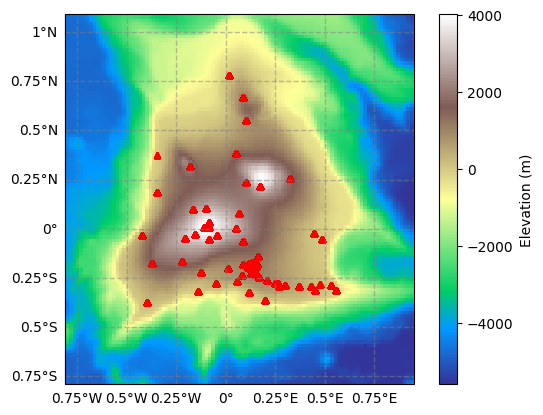

In [11]:
topo_rotated = xr.open_dataset('hawaii_rotated.nc')
ax = plot_basemap(region_new, feature=False)
h = ax.pcolor(topo_rotated.lon, topo_rotated.lat, topo_rotated.z,
              transform=ccrs.PlateCarree(), cmap='terrain')
ax.plot(sr_rotated['stlo'], sr_rotated['stla'], 'r^', markersize=5, transform=ccrs.PlateCarree())
ax.plot(sr_rotated['evlo'], sr_rotated['evla'], 'r^', markersize=5, transform=ccrs.PlateCarree())
plt.colorbar(h, ax=ax, label='Elevation (m)')